In [2]:
import os
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Définir le répertoire de cache pour le modèle de langage
os.environ["TFHUB_CACHE_DIR"] = "my_tfhub_cache"

In [4]:
# Charger le jeu de données IMDb Reviews
(ds_train, ds_test), ds_info = tfds.load('imdb_reviews', split=['train', 'test'], as_supervised=True, with_info=True)

In [5]:
# Convertir les données au format texte
train_texts = [str(text, 'utf-8') for text, label in tfds.as_numpy(ds_train)]
train_labels = np.array([label for text, label in tfds.as_numpy(ds_train)])
test_texts = [str(text, 'utf-8') for text, label in tfds.as_numpy(ds_test)]
test_labels = np.array([label for text, label in tfds.as_numpy(ds_test)])

In [6]:
# Charger le modèle Universal Sentence Encoder de TensorFlow Hub
embedding = "https://tfhub.dev/google/universal-sentence-encoder/4"
hub_layer = hub.KerasLayer(embedding, input_shape=[], dtype=tf.string, trainable=True)

In [7]:
# Obtenir les embeddings pour les données d'entraînement et de test
train_embeddings = hub_layer(train_texts)
test_embeddings = hub_layer(test_texts)

In [8]:
# Création du modèle
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(512,), dtype=tf.float32),  # Input Layer avec la forme des embeddings
    tf.keras.layers.Reshape((512,)),  # Reshape pour adapter la forme des embeddings
    tf.keras.layers.Dense(16, activation='relu'),  # Couche Dense avec 16 neurones
    tf.keras.layers.Dense(1, activation='sigmoid')  # Couche Dense de sortie avec activation sigmoid pour la classification binaire
])


In [9]:
# Compilation du modèle
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [10]:
# Entrainement du modèle avec les embeddings
history = model.fit(train_embeddings, train_labels, validation_split=0.1, epochs=10, batch_size=32)

Epoch 1/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7656 - loss: 0.5148 - val_accuracy: 0.8496 - val_loss: 0.3375
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8598 - loss: 0.3265 - val_accuracy: 0.8528 - val_loss: 0.3287
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8636 - loss: 0.3196 - val_accuracy: 0.8508 - val_loss: 0.3285
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8613 - loss: 0.3288 - val_accuracy: 0.8568 - val_loss: 0.3258
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8640 - loss: 0.3190 - val_accuracy: 0.8516 - val_loss: 0.3278
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8657 - loss: 0.3172 - val_accuracy: 0.8556 - val_loss: 0.3249
Epoch 7/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8692 - loss: 0.3118 - val_accuracy: 0.8532 - val_loss: 0.3251
Epoch 8/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8710 - loss: 0.3040 - val_accuracy: 0.

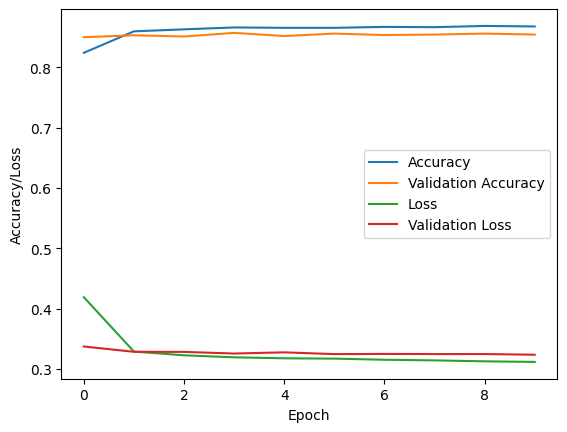

In [11]:
# Visualisation de l'historique de l'entraînement
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy/Loss')
plt.legend()
plt.show()

In [12]:
# Évaluer le modèle sur les données de test
test_loss, test_accuracy = model.evaluate(test_embeddings, test_labels)
print('Test Loss: ', test_loss)
print('Test Accuracy: ', test_accuracy)

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 853us/step - accuracy: 0.8557 - loss: 0.3267
Test Loss:  0.3229043185710907
Test Accuracy:  0.8578000068664551


In [13]:
# Prédiction sur les données de test
predictions = (model.predict(test_embeddings) > 0.5).astype("int32")

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


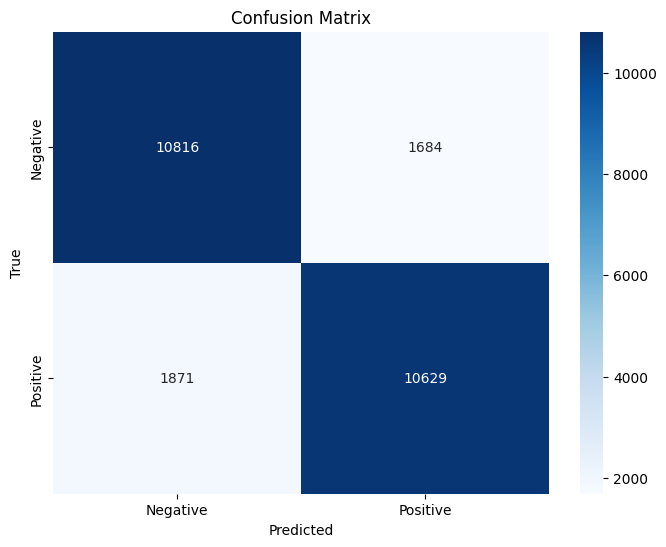

In [14]:
# Affichage de la matrice de confusion
cm = confusion_matrix(test_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [15]:
# Rapport de classification
print(classification_report(test_labels, predictions, target_names=['Negative', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.85      0.87      0.86     12500
    Positive       0.86      0.85      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000

